In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json

from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



import shutil
from utils.kernels import *
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import ConcatDataset
from torchvision.models import efficientnet_v2_s, resnet50, ResNet50_Weights, googlenet, efficientnet_b0, mobilenet_v3_large
from utils.eval import evaluate, validation_and_agreement, distance_models, validation_agreement_function_distance
from dataset_utils.data_utils import load_dataset, CIFAR100sparse2coarse



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Exploring the last layer weight matrices

In [3]:
def plot_matrix(M, title, size=(8,10)):
    fig, ax = plt.subplots(figsize=size)
    mat = ax.matshow(M)
    ax.set_title(title,fontsize=20)
    ax.tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
    ax.tick_params(axis='y', colors='black', bottom=True, top=False)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)

    plt.show()
    return fig

In [4]:
GPUID = 5
device = get_device([GPUID])

### IMAGENET

In [5]:
NUM_SAMPLES = 500000
NUM_BATCHES = 10

In [6]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', inference_transform)
all_indices = set(range(len(train_dataset)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(train_dataset, random_indices)
loader = DataLoader(data, batch_size=128, shuffle=False, num_workers=4, pin_memory=False)


In [7]:

def load_checkpoint(best=False, filename='checkpoint.pth.tar', student=False):
    path = base_path() + "chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)  
          if not student: 
              new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
              checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [8]:
# initialising the model
teacher =  resnet50(weights=None)
teacher = feature_wrapper(teacher)
teacher = head_wrapper(teacher)

CHKPT_NAME = 'rn50_2023-02-21_10-45-30_best.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50_2023-02-21_10-45-30_best.ckpt


In [9]:
for n,m in teacher.named_children():
    print(n)
    if n=='fc':
        head = m

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [10]:
W = head.weight.data.detach()
W

tensor([[-0.0049, -0.0109, -0.0156,  ..., -0.0101,  0.0289,  0.0046],
        [-0.0154,  0.0048, -0.0116,  ...,  0.0094,  0.0070,  0.0096],
        [-0.0063, -0.0537, -0.0027,  ..., -0.0179, -0.0146,  0.0203],
        ...,
        [-0.0044,  0.0838, -0.0190,  ..., -0.0071,  0.0063, -0.0448],
        [ 0.0090, -0.0227, -0.0007,  ..., -0.0117, -0.0243, -0.0195],
        [-0.0525, -0.0425,  0.0037,  ..., -0.0104, -0.0275, -0.0187]],
       device='cuda:5')

In [12]:
W.shape

torch.Size([1000, 2048])

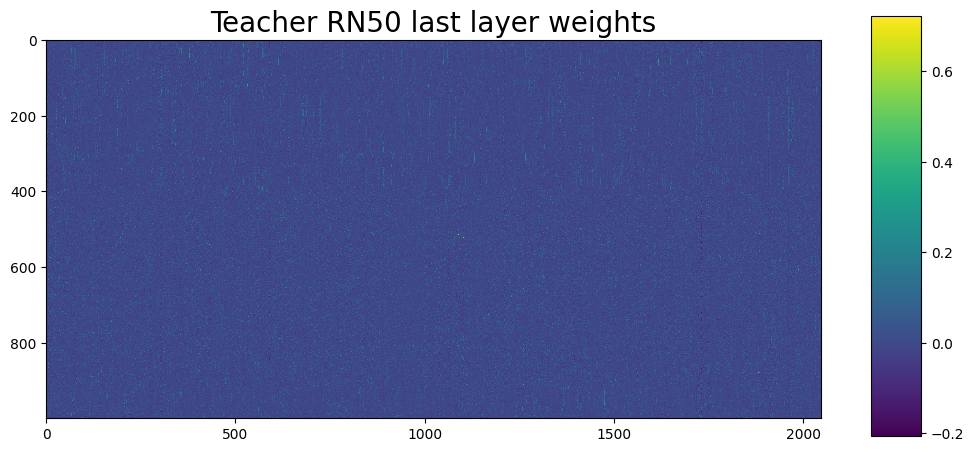

In [11]:
plot_matrix(W.cpu(), title="Teacher RN50 last layer weights", size=(10,6));

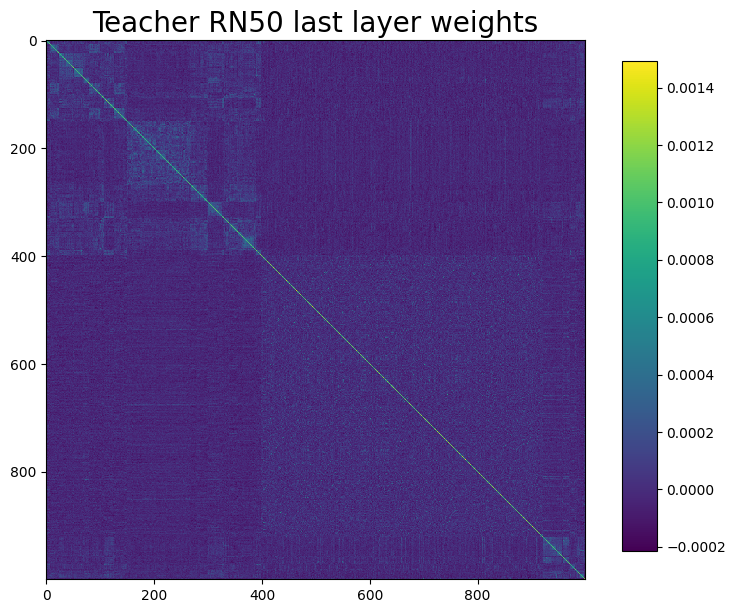

In [13]:
M = torch.matmul(W,W.T)/(torch.norm(W)**2)
plot_matrix(M.cpu(), title="Teacher RN50 last layer weights", size=(7,7));

In [13]:
torch.dist(M, torch.eye(W.size(1)).to(device))

tensor(44.3254, device='cuda:5')

In [14]:
mask = (torch.ones_like(M) - torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # off-diagonal average

tensor(5.5752e-06, device='cuda:5')

In [15]:
mask = (torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # diagonal average

tensor(1.1207e-05, device='cuda:5')

In [16]:
# initialising the model
student =  resnet50(weights=None)
student = feature_wrapper(student)

CHKPT_NAME = 'rn50-student-11-90000-0.0.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-90000-0.0.ckpt


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


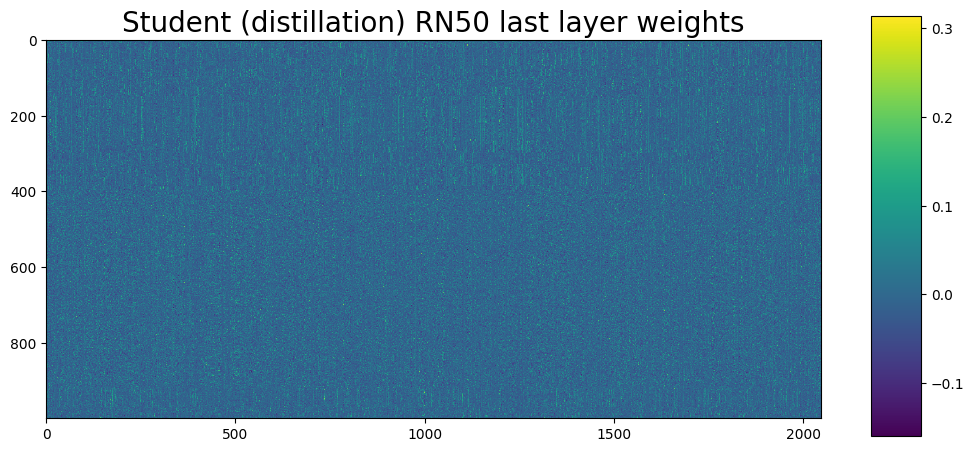

In [18]:
for n,m in student.named_children():
    print(n)
    if n=='fc':
        head = m

W = head.weight.data.detach()
W

plot_matrix(W.cpu(), title="Student (distillation) RN50 last layer weights", size=(10,6));


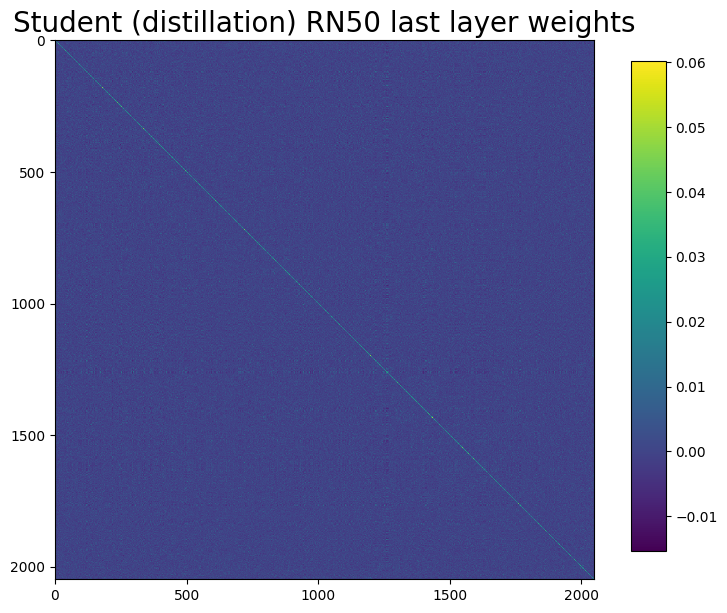

In [19]:
M = torch.matmul(W.T,W)/(torch.norm(W))
plot_matrix(M.cpu(), title="Student (distillation) RN50 last layer weights", size=(7,7));

In [20]:
torch.dist(M, torch.eye(W.size(1)).to(device))

tensor(44.4943, device='cuda:5')

In [21]:
mask = (torch.ones_like(M) - torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # off-diagonal average

tensor(1.0048e-05, device='cuda:5')

In [22]:
mask = (torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # diagonal average

tensor(9.6994e-06, device='cuda:5')

In [23]:
# initialising the model
student =  resnet50(weights=None)
student = feature_wrapper(student)

CHKPT_NAME = 'rn50-student-11-90000-1.0.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-90000-1.0.ckpt


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


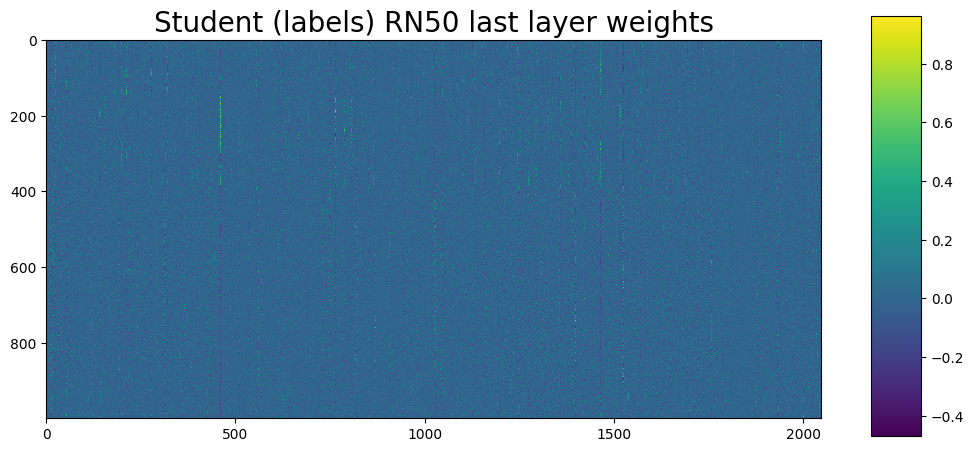

In [24]:
for n,m in student.named_children():
    print(n)
    if n=='fc':
        head = m

W = head.weight.data.detach()
W

plot_matrix(W.cpu(), title="Student (labels) RN50 last layer weights", size=(10,6));


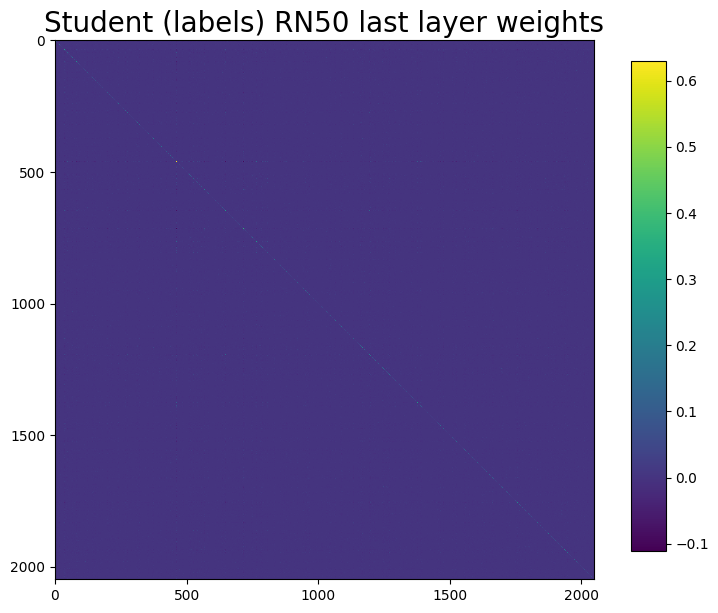

In [25]:
M = torch.matmul(W.T,W)/(torch.norm(W))
plot_matrix(M.cpu(), title="Student (labels) RN50 last layer weights", size=(7,7));

In [26]:
mask = (torch.ones_like(M) - torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # off-diagonal average

tensor(4.1084e-06, device='cuda:5')

In [27]:
mask = (torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # diagonal average

tensor(1.8401e-05, device='cuda:5')

In [28]:
torch.dist(M, torch.eye(W.size(1)).to(device))

tensor(43.8575, device='cuda:5')

### CIFAR 5M

In [6]:
NUM_SAMPLES = 500000

In [7]:

C5m_train, C5m_test = load_dataset('cifar5m', augment=False)

print(f"Randomly drawing {NUM_SAMPLES} samples for the Cifar5M base")
all_indices = set(range(len(C5m_train)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(C5m_train, random_indices)
loader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

Loading CIFAR 5mil...
Loaded part 1/6
Loaded part 2/6
Loaded part 3/6
Loaded part 4/6
Loaded part 5/6
Loaded part 6/6
Randomly drawing 500000 samples for the Cifar5M base


In [10]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', type='mnet'):
    """ Available network types: [mnet, convnet]"""
    path = base_path() + "chkpts" + "/" + "cifar5m" + "/" + f"{type}/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 


In [16]:
# ENTROPY = 0.35
teacher = mobilenet_v3_large(num_classes=10) # adjusting for CIFAR 
CHKPT_NAME = f'mnet-teacher.ckpt' 

In [ ]:
# ENTROPY = 2.26
teacher = make_cnn(c=20, num_classes=10, use_batch_norm=True)
CHKPT_NAME = f'convnet-teacher.ckpt' 

CNN made with 154250 parameters


In [26]:
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, type='mnet') 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar5m/mnet/mnet-teacher.ckpt


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:

SEEDS = [11, 13, 21, 33, 55]
BUFFER_SIZES = [1200, 6000, 12000, 24000, 60000, 120000, 600000]

In [30]:
student = mobilenet_v3_large(num_classes=10) # adjusting for CIFAR 
#student = make_cnn(c=20, num_classes=10, use_batch_norm=True)
seed = SEEDS[0]
buffer_size = BUFFER_SIZES[3]
alpha = 1.0
STUDNT_NAME = f'mnet-student-{seed}-{buffer_size}-{alpha}.ckpt'
#STUDNT_NAME = 'rn50-student-11-90000-1.0.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME, student=True) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-90000-1.0.ckpt


### CIFAR 100

In [30]:
NUM_BATCHES=30

In [31]:

C100_train, C100_val = load_dataset('cifar100', augment=False)
all_data = ConcatDataset([C100_train, C100_val])
shuffled_train = torch.utils.data.Subset(C100_train, torch.randperm(len(C100_train)).tolist())
loader = DataLoader(shuffled_train, batch_size=128, shuffle=False, num_workers=4, pin_memory=False)

In [32]:
len(loader)

391

In [33]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "chkpts" + "/" + "cifar100" + "/" + "resnet18/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 

Loading the teacher and checking the weights

In [34]:
# initialising the model
teacher = resnet18(num_classes=100)
#teacher = make_cnn(c=150, num_classes=100, use_batch_norm=True)
CHKPT_NAME = 'resnet18-teacher.ckpt'
#CHKPT_NAME = 'convnet150-teacher.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-teacher.ckpt


conv1
conv2_x
conv3_x
conv4_x
conv5_x
avg_pool
fc


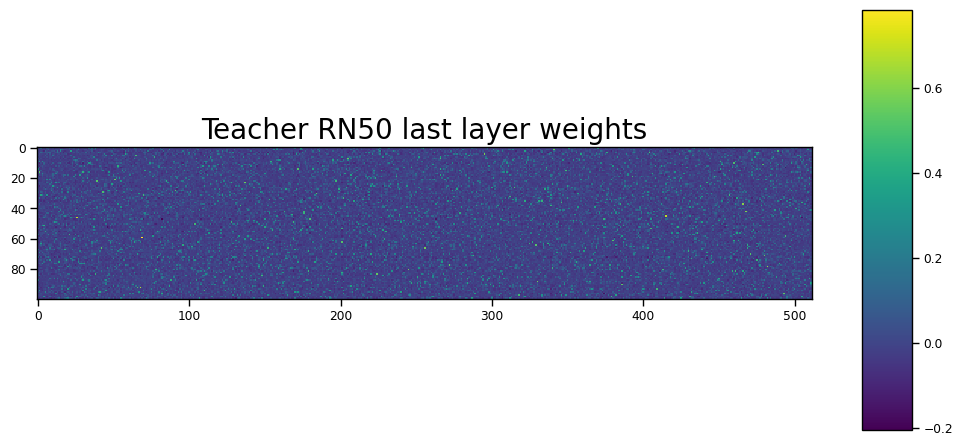

In [36]:
for n,m in teacher.named_children():
    print(n)
    if n=='fc':
        head = m

W = head.weight.data.detach()
W

plot_matrix(W.cpu(), title="Teacher RN50 last layer weights", size=(10,6));


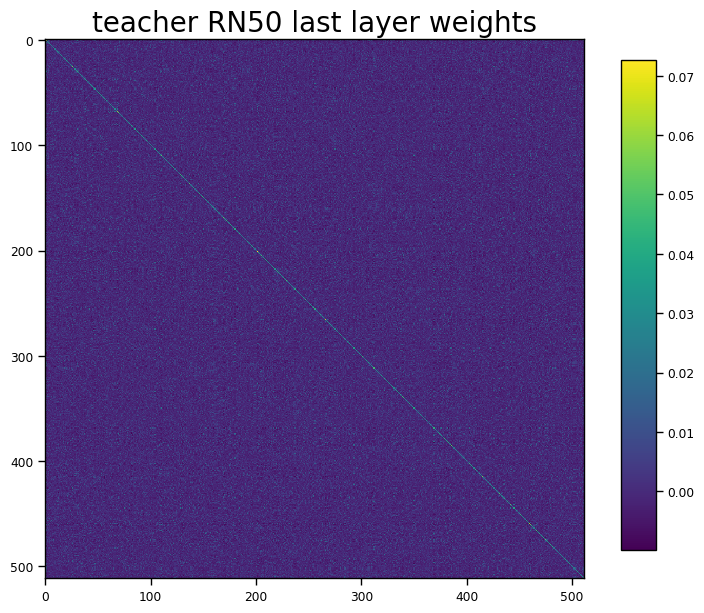

In [37]:
M = torch.matmul(W.T,W)/(torch.norm(W))
plot_matrix(M.cpu(), title="teacher RN50 last layer weights", size=(7,7));

In [39]:
torch.dist(M, torch.eye(W.size(1)).to(device))

tensor(22.0235, device='cuda:5')

In [40]:
mask = (torch.ones_like(M) - torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # off-diagonal average

tensor(-4.5982e-05, device='cuda:5')

In [41]:
mask = (torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # diagonal average

tensor(5.8208e-05, device='cuda:5')

Loading the students

In [42]:
student = resnet18(num_classes=100)
alpha = 0.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


conv1
conv2_x
conv3_x
conv4_x
conv5_x
avg_pool
fc


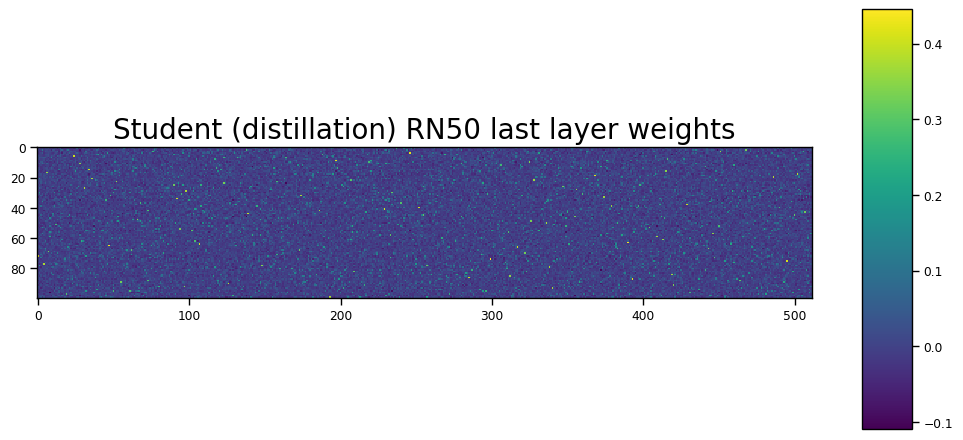

In [43]:
for n,m in student.named_children():
    print(n)
    if n=='fc':
        head = m

W = head.weight.data.detach()
W

plot_matrix(W.cpu(), title="Student (distillation) RN50 last layer weights", size=(10,6));


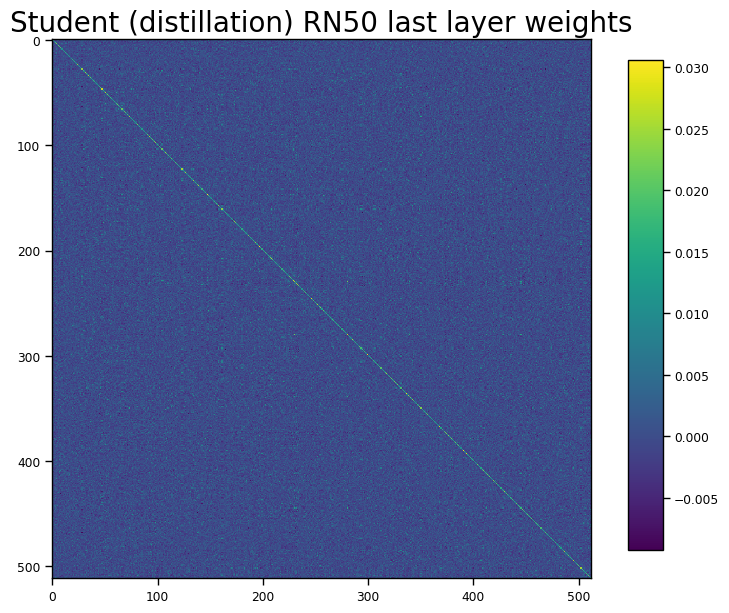

In [44]:
M = torch.matmul(W.T,W)/(torch.norm(W))
plot_matrix(M.cpu(), title="Student (distillation) RN50 last layer weights", size=(7,7));

In [45]:
torch.dist(M, torch.eye(W.size(1)).to(device))

tensor(22.2875, device='cuda:5')

In [46]:
mask = (torch.ones_like(M) - torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # off-diagonal average

tensor(-2.9118e-05, device='cuda:5')

In [47]:
mask = (torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # diagonal average

tensor(3.1250e-05, device='cuda:5')

Labels student now

In [48]:
student = resnet18(num_classes=100)
alpha = 1.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


conv1
conv2_x
conv3_x
conv4_x
conv5_x
avg_pool
fc


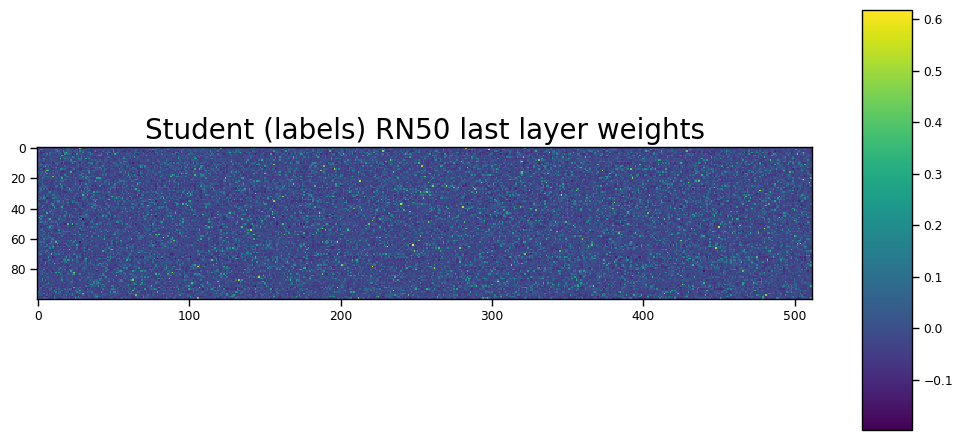

In [51]:
for n,m in student.named_children():
    print(n)
    if n=='fc':
        head = m

W = head.weight.data.detach()
W

plot_matrix(W.cpu(), title="Student (labels) RN50 last layer weights", size=(10,6));


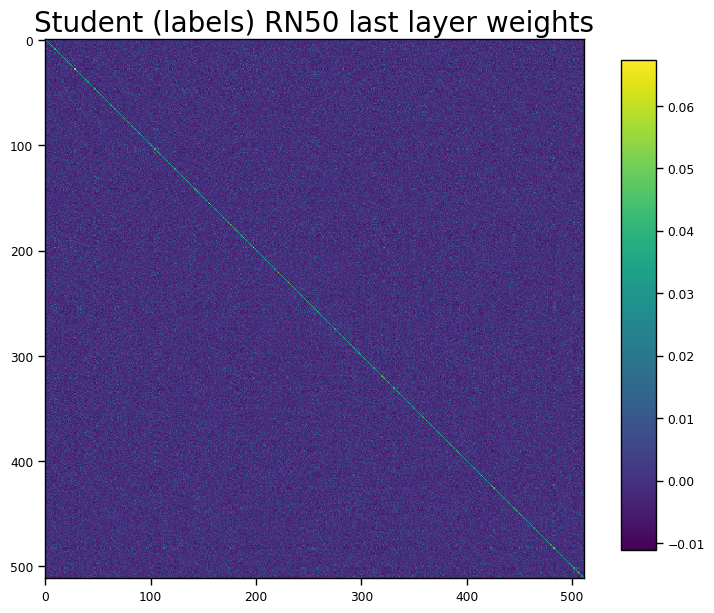

In [52]:
M = torch.matmul(W.T,W)/(torch.norm(W))
plot_matrix(M.cpu(), title="Student (labels) RN50 last layer weights", size=(7,7));

In [53]:
torch.dist(M, torch.eye(W.size(1)).to(device))

tensor(21.9896, device='cuda:5')

In [54]:
mask = (torch.ones_like(M) - torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # off-diagonal average

tensor(-4.9869e-05, device='cuda:5')

In [55]:
mask = (torch.eye(M.size(0)).to(device))
torch.mean(M*mask) # diagonal average

tensor(6.2232e-05, device='cuda:5')

## Neural collapse

### CIFAR 100

In [56]:
NUM_BATCHES=30

In [57]:

C100_train, C100_val = load_dataset('cifar100', augment=False)
all_data = ConcatDataset([C100_train, C100_val])
shuffled_train = torch.utils.data.Subset(C100_train, torch.randperm(len(C100_train)).tolist())
loader = DataLoader(shuffled_train, batch_size=128, shuffle=False, num_workers=4, pin_memory=False)

In [58]:
len(loader)

391

In [59]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "chkpts" + "/" + "cifar100" + "/" + "resnet18/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 

Loading the teacher and checking the weights

In [60]:
# initialising the model
teacher = resnet18(num_classes=100)
#teacher = make_cnn(c=150, num_classes=100, use_batch_norm=True)
CHKPT_NAME = 'resnet18-teacher.ckpt'
#CHKPT_NAME = 'convnet150-teacher.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-teacher.ckpt


In [68]:
def get_features(model, loader, device, num_batches=1): 
    
    total = 0
    progress_bar = ProgressBar(verbose=True)

    model = feature_wrapper(model) # adding 'get_features' function
    features = [] # we collect all the features in a matrix
    for i, data in enumerate(loader):
        if i==num_batches: break 
        with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                B = inputs.size(0)
                phi = model.get_features(inputs)
                # normalising the features to have norm one 
                phi = phi.view(B,-1)
                phi = torch.div(phi, phi.norm(dim=1).view(B,1))

                features.append(phi)

                total += B
                
        progress_bar.prog(i, len(loader), -1, 'Collecting features', i/(min(len(loader),num_batches)))  
    
    F = phi.size(1) # feature dimensionality
    features = torch.vstack(features).view(total, F).cpu().numpy()
    return features


In [69]:
Phi = get_features(teacher, loader, device, NUM_BATCHES)

[ 12-12 | 12:34 ] Task Collecting features | epoch -1: |███┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 387.98 ep/h | loss: 0.96666667 |

In [74]:
np.linalg.matrix_rank(Phi), Phi.shape

(512, (3840, 512))

Loading the students

In [75]:
student = resnet18(num_classes=100)
alpha = 0.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


In [76]:
Phi_S0 = get_features(student, loader, device, NUM_BATCHES)
np.linalg.matrix_rank(Phi_S0), Phi_S0.shape

[ 12-12 | 12:36 ] Task Collecting features | epoch -1: |███┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 380.78 ep/h | loss: 0.96666667 |

(512, (3840, 512))

In [77]:
student = resnet18(num_classes=100)
alpha = 1.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


In [78]:
Phi_S1 = get_features(student, loader, device, NUM_BATCHES)
np.linalg.matrix_rank(Phi_S1), Phi_S1.shape

[ 12-12 | 12:37 ] Task Collecting features | epoch -1: |███┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 381.84 ep/h | loss: 0.96666667 |

(512, (3840, 512))